# lab 07 1 learning_rate_and_evaluation
* Learning Rate와 Evaluation에 대한 설명

### 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

tf.set_random_seed(777)  # for reproducibility

print(tf.__version__)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


### 강의에 설명할 Data입니다
* x_data가 3차원 배열이기에 3차원 공간에 표현하여 x1과 x2, x3를 기준으로 y_data 3개 클래스를 구분하는 예제입니다
* 해당 Data를 3개의 색상으로 구분해서 출력해 보겠습니다.(파랑-2, 초록-1, 빨강-0)

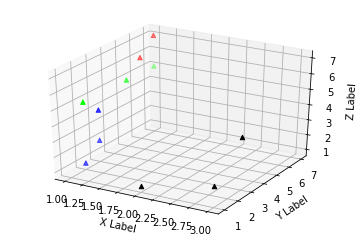

In [2]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

# Evaluation our model using this test dataset
x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]


x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]
x3 = [x[2] for x in x_train]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3, c=y_train, marker='^')

ax.scatter(x_test[0][0], x_test[0][1], x_test[0][2], c="black", marker='^')
ax.scatter(x_test[1][0], x_test[1][1], x_test[1][2], c="black", marker='^')
ax.scatter(x_test[2][0], x_test[2][1], x_test[2][2], c="black", marker='^')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

##  Tensorflow Session
### 위 Data를 기준으로 Learning Rate 값과 평가 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train)).repeat()

iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

features = tf.cast(features, tf.float32)
labels = tf.cast(labels, tf.float32)

### 위 Data를 기준으로 가설의 검증을 통해 Softmax Classification 모델을 만들도록 하겠습니다
* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([3, 3],tf.zeros([3,3]) )

In [4]:
W = tf.Variable(tf.random_normal([3, 3]))
b = tf.Variable(tf.random_normal([3]))

### Softmax 함수를 가설로 선언합니다
* Softmax를 통해 가장 높은 값을 구한다 (0~1사이의 값 합계는 1)

In [5]:
# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
hypothesis = tf.nn.softmax(tf.matmul(features, W) + b)

### 가설을 검증할 Cost 함수를 정의합니다
* Cross Entropy loss를 사용

In [6]:
# Cross entropy cost/loss
cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(hypothesis), axis=1))

### Learning Rate 값을 조정하기 위한 Learning Decay 설정 
#### 5개 파라미터 설정
* starter_learning_rate : 최초 학습시 사용될 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
* global_step : 현재 학습 횟수
* 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
* 0.96 : 기존 learning에 곱할 값
* 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [7]:
is_decay = True
starter_learning_rate = 0.1
    
if(is_decay):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # optimizer_obj = tf.train.AdamOptimizer(learning_rate=lr,beta1=0.7, beta2=.3, name='Adam-op')
    optimizer_obj = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = optimizer_obj.minimize(cost, global_step=global_step)
else:
    optimizer_obj = tf.train.GradientDescentOptimizer(learning_rate=starter_learning_rate)
    optimizer = optimizer_obj.minimize(cost)#1e-10

### 가설을 통해 실재 값과 비교한 정확도를 측정합니다

In [8]:
# Correct prediction Test model
prediction = tf.argmax(hypothesis, 1)
is_correct = tf.equal(prediction, tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

### Tensorflow를 통한 실행을 위해 Session를 선언합니다.
* 위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성합니다. 
* Learning 값을 출력한다 _learning_rate adam사용 시에는 _lr
* Test Data값 검증 수행 [2, 1, 1], [3, 1, 2], [3, 3, 4]

In [9]:
EPOCHS = 10001

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(EPOCHS):
        sess.run(iter.initializer)
        _, loss_value = sess.run([optimizer, cost])
        if step % 1000 == 0:
            if(is_decay):
                lr_value = sess.run(optimizer_obj._learning_rate)
            else:
                lr_value = starter_learning_rate
            print("Iter: {}, Loss: {:.4f}, Learning Rate: {:.4f}".format(step, loss_value, lr_value))  
    c, a = sess.run([prediction, accuracy])
    print("Correct (Y): ", c, "\nAccuracy: ", a)
    print("\nTest Data : {}, Predict : {}".format(x_test, sess.run(prediction, feed_dict={features: x_test})))
    print("Accuracy : {}".format(sess.run(accuracy, feed_dict={features: x_test, labels: y_test})))

Iter: 0, Loss: 6.0257, Learning Rate: 0.1000
Iter: 1000, Loss: 0.3723, Learning Rate: 0.0960
Iter: 2000, Loss: 0.2779, Learning Rate: 0.0922
Iter: 3000, Loss: 0.2293, Learning Rate: 0.0885
Iter: 4000, Loss: 0.1977, Learning Rate: 0.0849
Iter: 5000, Loss: 0.1750, Learning Rate: 0.0815
Iter: 6000, Loss: 0.1575, Learning Rate: 0.0783
Iter: 7000, Loss: 0.1438, Learning Rate: 0.0751
Iter: 8000, Loss: 0.1326, Learning Rate: 0.0721
Iter: 9000, Loss: 0.1233, Learning Rate: 0.0693
Iter: 10000, Loss: 0.1155, Learning Rate: 0.0665
Correct (Y):  [2 2 2 1 1 1 0 0] 
Accuracy:  1.0

Test Data : [[2, 1, 1], [3, 1, 2], [3, 3, 4]], Predict : [2 2 2]
Accuracy : 1.0
